In [1]:
import torch
import torch.nn.functional as torchFunc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", 'r').read().splitlines()

In [3]:
characters = sorted(list(set(''.join(words))))
char_to_int = {s:i+1 for i,s in enumerate(characters)}
char_to_int['.'] = 0
int_to_char = {i:s for s,i in char_to_int.items()}
print(int_to_char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Building a database to train on database.<br>
Will have context and output.<br>
For emma, possible database is (given block size is 3)
<ul>
<li>... -> e</li>
<li>..e -> m</li>
<li>.em -> m</li>
</ul>

In [4]:
block_size = 3
context_set, result_set = [], []

for word in words[:8]:
    context = [0]*block_size # '...' -> initial context

    for character in word + '.':
        result = char_to_int[character]
        context_set.append(context)
        result_set.append(result)
        
        # print(''.join(int_to_char[i] for i in context), "-->", character)

        context = context[1:] + [result]

X = torch.tensor(context_set)
Y = torch.tensor(result_set)

In [19]:
embeddings_size = 2
look_up = torch.randn((27, embeddings_size))
# look_up[5]
# torchFunc.one_hot(torch.tensor(5), num_classes=27).float() @ look_up

<h3>Embedding strips down dimension</h3>
In our case, we have 27 dimension, 27 possible character
We strip it to 2 dimension

After embedding calculation, we need a way to look up table of some sort, 
that can take any character and output that embedded value

In our case, look_up is that table

<h3>We can access look up in two ways</h3>
look_up[ix] to get the necessary vector
also we can do this
look_up matmul one_hot(ix)

Both results in same stuff... only this time, 
the entire look_up then also becomes a part of the neural net 
and can be used as weights of the first layer

<h3>Now actual algorithm</h3>

input is 3 element context, each is embedded to 2D vector... <br>
input is 6 dimensional<br>

output hyper parameter... we choose 100 just because<br>
bias adds to all output so 100 dimension<br>

In [25]:
internal_output_size = 100
Weight_1 = torch.randn((6, internal_output_size))
bias_1 = torch.randn((internal_output_size))

In [26]:
embeddings = look_up[X]
embeddings = embeddings.view(-1, embeddings_size * block_size)
# view attribute manipulate internal attributes to change shape... main memory does not get changed
embeddings.shape

torch.Size([53, 6])

In [27]:
output_1 = torch.tanh(embeddings @ Weight_1 + bias_1)
output_1.shape

torch.Size([53, 100])

In [28]:
Weight_2 = torch.randn((internal_output_size, 27))
bias_2 = torch.randn((27))
logits = output_1 @ Weight_2 + bias_2
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)

prob.shape

torch.Size([53, 27])

In [33]:
loss = -prob[torch.arange(53), Y].log().mean()
loss

tensor(16.9811)

In [34]:
#------------------ now cleaning up ----------------#

In [35]:
X.shape, Y.shape # dataset

(torch.Size([53, 3]), torch.Size([53]))

In [36]:
g = torch.Generator().manual_seed(2147483647)
look_up = torch.randn((27, 2), generator=g)
internal_output_size = 100
Weight_1 = torch.randn((6, internal_output_size), generator=g)
bias_1 = torch.randn((internal_output_size), generator=g)
Weight_2 = torch.randn((internal_output_size, 27), generator=g)
bias_2 = torch.randn((27), generator=g)
parameters = [look_up, Weight_1, bias_1, Weight_2, bias_2]

In [37]:
sum(p.nelement() for p in parameters)

3481

In [40]:
embeddings = look_up[X].view(-1, embeddings_size * block_size)
output_1 = torch.tanh(embeddings @ Weight_1 + bias_1)
logits = output_1 @ Weight_2 + bias_2
# counts = logits.exp()
# prob = counts / counts.sum(dim=1, keepdim=True)
# loss = -prob[torch.arange(53), Y].log().mean()
loss = torchFunc.cross_entropy(logits, Y) # all of the above... in one beautiful line
loss

tensor(16.1878)

In [41]:
#------------------ more cleaning up ----------------#

In [35]:
import torch
import torch.nn.functional as torchFunc
import matplotlib.pyplot as plt
%matplotlib inline

# word list
words = open("names.txt", 'r').read().splitlines()
characters = sorted(list(set(''.join(words))))
char_to_int = {s:i+1 for i,s in enumerate(characters)}
char_to_int['.'] = 0
int_to_char = {i:s for s,i in char_to_int.items()}

# database creation
block_size = 3
context_set, result_set = [], []

for word in words:
    context = [0]*block_size # '...' -> initial context

    for character in word + '.':
        result = char_to_int[character]
        context_set.append(context)
        result_set.append(result)

        context = context[1:] + [result]

X = torch.tensor(context_set)
Y = torch.tensor(result_set)

print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [51]:
# generating parameters
g = torch.Generator().manual_seed(2147483647)
internal_output_size = 100
embeddings_size = 2

look_up = torch.randn((27, embeddings_size), generator=g, requires_grad=True)
Weight_1 = torch.randn((6, internal_output_size), generator=g, requires_grad=True)
bias_1 = torch.randn((internal_output_size), generator=g, requires_grad=True)
Weight_2 = torch.randn((internal_output_size, 27), generator=g, requires_grad=True)
bias_2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [look_up, Weight_1, bias_1, Weight_2, bias_2]


In [19]:
# for _ in range(10):
#     # forward pass
#     embeddings = look_up[X].view(-1, embeddings_size * block_size)
#     output_1 = torch.tanh(embeddings @ Weight_1 + bias_1)
#     logits = output_1 @ Weight_2 + bias_2
#     loss = torchFunc.cross_entropy(logits, Y)
#     print(loss.item())

#     # backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     #update
#     for p in parameters:
#         p.data += -0.1 * p.grad

# print(loss.item())

10.709589004516602
10.407635688781738
10.127811431884766
9.86436939239502
9.614506721496582
9.376442909240723
9.14894962310791
8.93111515045166
8.722233772277832
8.52175235748291
8.52175235748291


In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

In [54]:
# better solution -> generating minibatch
# learning_rate_index = []
# loss_index = []
learning_rate = 10 ** -0.7
learning_rate *= .1
for i in range(100000):

    # minibatch construct (32 element at a time)
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    embeddings = look_up[X[ix]].view(-1, embeddings_size * block_size)
    output_1 = torch.tanh(embeddings @ Weight_1 + bias_1)
    logits = output_1 @ Weight_2 + bias_2
    loss = torchFunc.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    # learning_rate = lrs[i]
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track
    # learning_rate_index.append(lre[i])
    # loss_index.append(loss.item())

print(loss.item())

2.022517204284668


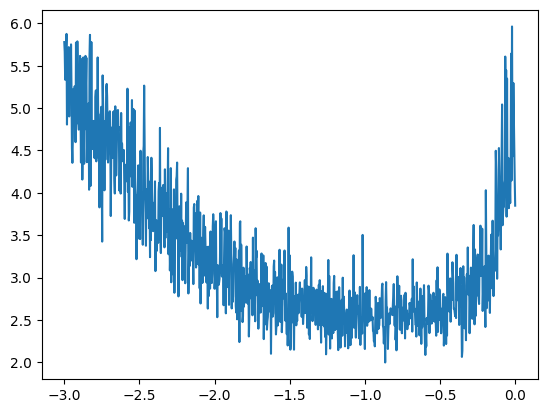

In [47]:
# plt.plot(learning_rate_index, loss_index)

In [55]:
# loss for all
embeddings = look_up[X].view(-1, embeddings_size * block_size)
output_1 = torch.tanh(embeddings @ Weight_1 + bias_1)
logits = output_1 @ Weight_2 + bias_2
loss = torchFunc.cross_entropy(logits, Y)
print(loss.item())

2.210862636566162
